In [2]:
import sys
sys.path[0] = ('/home/labs/waic/omrik/DNN-Challenge')
from fastai.vision import *
import pre
import resample
from metrics import Pearson

root = Path('../data').resolve()
train = root / 'train'
val = root / 'val'

In [3]:
def normalize_time(series):
    # 1440 minutes in a day
    normalized = (series.hour * 60 + series.minute) / 1440
    return normalized

def get_data(data_dir):
    cgm, meals = pre.get_dfs(data_dir)
    meals = resample.resample_meals(cgm, meals, 15)
    meals = pd.concat((meals, cgm), axis=1)
    meals['time'] = normalize_time(meals.index.get_level_values('Date'))
    cgm, y = pre.build_cgm(cgm, drop=True)
    return cgm, meals, y

class ContData(Dataset):
    def __init__(self, cgm, meals, y):
#         self.cgm = cgm.loc[y.index].dropna(how='any', axis=0)
        self.cgm = cgm
        self.meals = meals
        self.y = y
        
    def __len__(self):
        return len(self.cgm)
    
    def __getitem__(self, i):
        index = self.meals.index.get_loc(self.cgm.index[i])
        values = self.meals[index-48:index+1].values
        target = self.y.iloc[i].values
        x, y = torch.tensor(values, dtype=torch.float), torch.tensor(target, dtype=torch.float)
        return x, y

In [ ]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Linear(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input)
        output = embedded
        output, hidden = self.gru(output[None], hidden)
        return output[0], hidden

    def initHidden(self, bs, device):
        return torch.zeros(1, bs, self.hidden_size, device=device)


## Seq2Lin

In [4]:
train_data = get_data(train)
val_data = get_data(val)

train_ds = ContData(*train_data)
val_ds = ContData(*val_data)

data = DataBunch.create(train_ds, val_ds, bs=512)
data

/home/labs/waic/omrik/DNN-Challenge/pre.py:74: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  X = X.loc[y.index].dropna(how='any', axis=0)


DataBunch;

Train: <__main__.ContData object at 0x7fdbbbc38d30>;

Valid: <__main__.ContData object at 0x7fdcc27c7978>;

Test: None

In [6]:
class WindowPearson(Pearson):
    def __init__(self, gt):
        super().__init__(gt)
        
    def on_batch_end(self, last_output, last_target, **kwargs):
        super().on_batch_end(last_output[-1], last_target, **kwargs)
        
p = WindowPearson(val_ds.y)

def loss(outputs, targets):
    targets = targets[None].expand_as(outputs)
    return F.mse_loss(outputs, targets)

In [9]:
MAX_LENGTH = 49


class Seq2Lin(Module):
    def __init__(self, input_size, hidden_size, num_layers=1, dropout=0):
        super().__init__()
        self.encoder = nn.LSTM(input_size, hidden_size, num_layers=num_layers, dropout=dropout)
        self.decoder = nn.Linear(hidden_size, 8)

        
    def forward(self, input):
        input = input.transpose(0, 1)
        encoder_outputs, _ = self.encoder(input)
        out = self.decoder(encoder_outputs)
        return out

In [10]:
model = Seq2Lin(38, 128, num_layers=4)
metrics = [mean_absolute_error, Pearson(val_ds.y)]
learner = Learner(data, model, loss_func=loss, metrics=p)

epoch,train_loss,valid_loss,window_pearson,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 2.51E-06


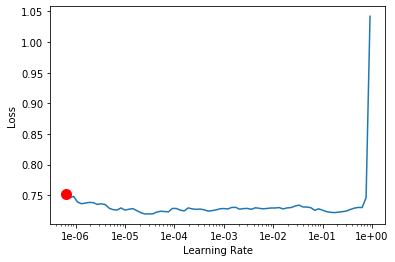

In [11]:
learner.lr_find()
learner.recorder.plot(suggestion=True)

In [12]:
learner.fit_one_cycle(10, 1e-2)

epoch,train_loss,valid_loss,window_pearson,time
0,0.713640,0.688159,0.423856,08:05
1,0.698931,0.666701,0.523480,08:02
2,0.684193,0.663920,0.531217,08:01


KeyboardInterrupt: 

In [13]:
def get_data(data_dir):
    cgm, meals = pre.get_dfs(data_dir)
    meals = resample.resample_meals(cgm, meals, 15)
    meals = pd.concat((meals, cgm), axis=1)
    meals['time'] = normalize_time(meals.index.get_level_values('Date'))
    cgm, y = pre.build_cgm(cgm, drop=False)
    return cgm, meals, y

class ContData(Dataset):
    def __init__(self, cgm, meals, y):
        self.cgm = cgm.loc[y.index].dropna(how='any', axis=0)
        self.meals = meals
        self.y = y
        
    def __len__(self):
        return len(self.cgm)
    
    def __getitem__(self, i):
        index = self.meals.index.get_loc(self.cgm.index[i])
        values = self.meals[index-48:index+1].values
        index = self.y.index.get_loc(self.cgm.index[i])
        target = self.y.iloc[index-48:index+1]
        x, y = torch.tensor(values, dtype=torch.float), torch.tensor(target.values, dtype=torch.float)
        return x, y
    
def loss(outputs, targets, start_idx=0):
    targets = targets.transpose(0, 1)
    return F.mse_loss(outputs[start_idx:], targets[start_idx:])

In [14]:
train_data = get_data(train)
val_data = get_data(val)

In [15]:
train_ds = ContData(*train_data)
val_ds = ContData(*val_data)
data = DataBunch.create(train_ds, val_ds, bs=512)
data

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:11: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  # This is added back by InteractiveShellApp.init_path()


DataBunch;

Train: <__main__.ContData object at 0x7fdc6c0d9080>;

Valid: <__main__.ContData object at 0x7fdbb96e1c88>;

Test: None

In [18]:
model = Seq2Lin(38, 128, num_layers=4)
learner = Learner(data, model, loss_func=loss, metrics=p)


In [ ]:
learner.lr_find()
learner.recorder.plot(suggestion=True)

In [20]:
learner.fit_one_cycle(10, 5e-4)

epoch,train_loss,valid_loss,window_pearson,time
0,0.478962,0.471839,0.611440,11:01
1,0.455583,0.452023,0.621115,11:01
2,0.439349,0.440751,0.632686,10:53
3,0.429766,0.436243,0.633421,10:48
4,0.418957,0.439638,0.631094,10:45
5,0.409227,0.445055,0.623833,10:47
6,0.402649,0.450870,0.620214,10:47
7,0.393733,0.462724,0.609364,10:40
8,0.385607,0.462269,0.607789,10:39
9,0.385677,0.463690,0.605552,10:42


In [24]:
model = Seq2Lin(38, 128, num_layers=4, dropout=0.2)
learner = Learner(data, model, loss_func=loss, metrics=p)

epoch,train_loss,valid_loss,window_pearson,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.10E+00
Min loss divided by 10: 7.59E-08


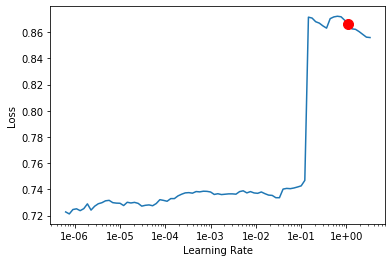

In [25]:
learner.lr_find()
learner.recorder.plot(suggestion=True)

In [26]:
learner.fit_one_cycle(10, 5e-4)

epoch,train_loss,valid_loss,window_pearson,time
0,0.509682,0.486182,0.595416,09:38
1,0.463333,0.454854,0.624715,09:39
2,0.445549,0.440629,0.632793,09:40
3,0.435998,0.437687,0.632472,09:40
4,0.430494,0.438736,0.632737,09:59
5,0.424911,0.439857,0.630549,10:20
6,0.418920,0.442959,0.629582,09:29
7,0.417711,0.444574,0.627181,09:28
8,0.414225,0.447475,0.626225,09:33
9,0.410197,0.446792,0.625919,09:52


In [ ]:
learner.lr_find()
learner.recorder.plot(suggestion=True)

In [27]:
class AddNoise(Callback):
    
    def __init__(self, std):
        self.std = std
        
    def on_batch_begin(self, last_input, last_target, train, **kwargs):
        if not train:
            return
        
        size = last_input.shape[:2]
        noise = torch.normal(0, self.std, size).to(last_input.device)
        last_input[..., -2] += noise
        return {'last_input': last_input}


In [32]:
model = Seq2Lin(38, 128, num_layers=4, dropout=0.2)
learner = Learner(data, model, loss_func=loss, metrics=p, callbacks=AddNoise(0.05))

epoch,train_loss,valid_loss,window_pearson,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 9.12E-07
Min loss divided by 10: 3.31E-07


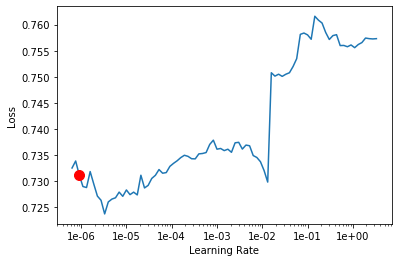

In [33]:
learner.lr_find()
learner.recorder.plot(suggestion=True)

In [34]:
learner.fit_one_cycle(10, 5e-4)

epoch,train_loss,valid_loss,window_pearson,time
0,0.511123,0.488319,0.591110,09:30
1,0.468629,0.453610,0.619568,09:29
2,0.452689,0.444522,0.627493,09:27
3,0.443776,0.439119,0.633855,09:27
4,0.433482,0.439650,0.632818,09:29
5,0.426966,0.442631,0.627600,09:29
6,0.421937,0.445014,0.626811,12:26
7,0.419939,0.447102,0.624437,10:28
8,0.417780,0.449449,0.621458,09:15
9,0.417828,0.448690,0.621703,09:17
